# Mutual Fund Style Classification from Prospectus
## Questrom School of Business

### 目标：use the mutual fund text summaries to predict which investment strategy each fund uses

# Setup
### 导入数据，导入包

<h3>Data</h3>
We will work on 2 Corpuses (or set of texts). All the texts or publicly available texts dealing with mutual funds. More precisely, the text has been extracted from the prospectuses of Mutual funds.
<ul>
  <li><u>MutualFundSummary</u><br>
      This file contains around 500 fund summaries in text files. A summary is the part of the prospectus that summaries the objective of the fund, the principal strategy, the decomposition of the fees, the principal risks that face the fund and some other information about the management of the fund.
  </li>
  <li><u>MutualFundLabels.csv</u><br>
      This table contains information about around 400 mutual funds. We will mostly focus on the "derivative" column that states whereas funds use derivatives or not. (the precise schema of the table is given later)
  </li>
</ul>


Let's first setup our environment.

I recommend you add a <b>GPU</b> to the colab virtual machine. <br>
Edit -> Notebook settings -> Hardware accelerator -> GPU -> SAVE


In [2]:
# Install tensorflow 2 to the virtual environment.
!pip install "tensorflow>=2.15.0"
!pip install --upgrade tensorflow-hub

# Restart Runtime after installation !
# -> Runtime -> Restart Runtime...
# Rerun the cell when the runtime has restarted

In [3]:
# Uncomment if you are using colab. Now we connect the colab notebook to our drive to access the data.
from google.colab import drive
drive.mount('/content/gdrive')
# Run the cell and follow the instructions

Mounted at /content/gdrive


In [4]:
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
print(tf.__version__)

2.15.0


In [8]:
DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app'

SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

#HEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesHealthy.csv")
#UNHEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesUnhealthy.csv")

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

# Util
Some useful functions. <br>
You don’t really need to understand them, these are utilities functions.


In [9]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

# Use pre-trained model (for example, sentence Bert) to extract key sentences of each summary

***1.Split the data into training, validation, and testing. ***

---

还没划分好

导入数据

In [10]:
# Get the summaries
fund_names, summaries = get_data(SUMMARY_PATH)
# The reading function can take several minutes depending on your internet connection.
# The reading function store the data in the cache so that rerunning the cell should be must faster.

In [11]:
fund_names

['AB Arizona Portfolio',
 'AB Asia ex-Japan Equity Portfolio',
 'AB Credit Long/Short Portfolio',
 'AB Balanced Wealth Strategy Portfolio',
 'AB Bond Inflation Strategy',
 'AB All Market Real Return Portfolio',
 'AB All Market Income Portfolio',
 'AB Discovery Value Fund',
 'AB Dynamic Asset Allocation Portfolio',
 'AB FlexFee International Strategic Core Portfolio',
 'AB FlexFee Emerging Markets Growth Portfolio',
 'AB FlexFee Core Opportunities Portfolio',
 'AB Global Risk Allocation-Moderate Portfolio',
 'AB FlexFee Large Cap Growth Portfolio',
 'AB Global Thematic Growth Portfolio',
 'AB Income Fund',
 'AB Limited Duration High Income Portfolio',
 'AB Intermediate Bond Portfolio',
 'AB Massachusetts Portfolio',
 'AB Minnesota Portfolio',
 'AB Municipal Bond Inflation Strategy',
 'AB Tax-Aware Fixed Income Portfolio',
 'AB New York Portfolio',
 'AB New Jersey Portfolio',
 'AB Small Cap Value Portfolio',
 'AB Pennsylvania Portfolio',
 'AB Small/Mid Cap Value Portfolio',
 'AB Real Est

设置分词器，删除停用词。

The following tokenizer function takes a text as input. The function removes the stopwords, the tokens with no letters and returns a list of the remining tokens.

In [14]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

In [15]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [16]:
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

More cleaning could be done. We could for instance remove the tokens that have less than 3 letters or all the tokens that contains non-letter characters. <br>
Then we create one long list of tokens by tokenizing all the summaries with our "tokenizer" function and concatenating all the summaries.


In [17]:
text_words = np.concatenate([tokenizer(summary) for summary in summaries])

In [18]:
print(text_words[:20])

['ab' 'arizona' 'portfolio' 'investment' 'objective' 'investment'
 'objective' 'portfolio' 'earn' 'highest' 'level' 'current' 'income'
 'exempt' 'federal' 'income' 'tax' 'state' 'arizona' 'personal']


使用预训练模型从summary中获得key sentences

In [19]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [20]:
from sentence_transformers import SentenceTransformer
import numpy as np

In [21]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
from nltk.tokenize import sent_tokenize

def split_sentences(summary):
    return sent_tokenize(summary)

sentences_list = [split_sentences(summary) for summary in summaries]

In [23]:
def extract_embeddings(sentences):
    embeddings = model.encode(sentences)
    return embeddings

embeddings_list = [extract_embeddings(sentences) for sentences in sentences_list]

KeyboardInterrupt: 

# C- Sentence extraction

<h3>Objective</h3>
Our objective for the next two parts is to create a model that will be able to predict if a fund uses derivatives based on the summary.
The first step is to extract from the summaries the sentences that deals with derivatives.


<h3> 1_ Create a knowledge base </h3>

<b>What is a knowledge base? </b><br>
A knowledge base is an explicitly formulated domain or word knowledge. In other words, in language models, a knowledge base is a semantic dataset which is informing the model part of the pipeline. A knowledge base provides the computer with this semantic context while it is analysing the input data. For instance, A Knowledge base might contain definitions of entities or the sentiment of particular words. Systems based on knowledge base are widely used in NLP, this paper (https://pdfs.semanticscholar.org/6d85/d867de2fdb8d2e094a429a48ff4749b05603.pdf) give a good overview of KB-NLP systems (knowledge-based system). <br>
In our case, we will create a very simple knowledge base that only describes one domain: Derivatives. This knowledge base will be a simple set of words related to derivatives. This set defines the Entity derivatives.


<b>Why do we want to create a knowledge base? </b><br>
The objective of this section is to extract sentences that deals with the use of derivatives in the fund summaries. Having a knowledge base that gives a broad definition of Derivatives will allows us to score each sentence accordingly to their distance to the Entity Derivatives. The sentences that are the closer to our knowledge base are more likely to discuss about derivatives and will therefore be extracted.


<b>How we create the knowledge base? </b><br>
To create the knowledge base, we will use the word2vec we trained above. We start from a list of related words and extend this list by adding the "num_neighbors" closer words (in terms of distance in our word2vec space) of each word of this list.


In [ ]:
key_words = ['bond', 'cash', 'swap', 'swaps', 'derivative', 'derivatives', 'futures', 'options', 'put', 'call', 'loan', 'loans', 'synthetic', 'underlying']

In [ ]:
word2vec = load_word2vec(glove_word2vec)

In [ ]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [ ]:
#word2vec = load_word2vec(our_word2vec)
knowledge_base = create_knowledge_base(5, word2vec, key_words)

bond not in word2vec
cash not in word2vec
swap not in word2vec
swaps not in word2vec
derivative not in word2vec
derivatives not in word2vec
futures not in word2vec
options not in word2vec
put not in word2vec
call not in word2vec
loan not in word2vec
loans not in word2vec
synthetic not in word2vec
underlying not in word2vec



We can now take a look at our knowledge base



In [ ]:
print(knowledge_base)

{'negotiating', 'loans', 'bonds', 'mortgages', 'ask', 'derivative', 'fundamental', 'asking', 'loan', 'money', 'trades', 'cash', 'negotiate', 'arbitrage', 'perception', 'treasury', 'commodity', 'trading', 'options', 'structural', 'out', 'option', 'calls', 'polymers', 'variable', 'swap', 'deals', 'swapping', 'considering', 'call', 'pay', 'synthetic', 'interest', 'paying', 'treasuries', 'stock', 'fibers', 'bond', 'derivatives', 'swaps', 'putting', 'underlying', 'resin', 'covariant', 'benchmark', 'paid', 'analogous', 'payments', 'lenders', 'resins', 'offer', 'but', 'credit', 'put', 'futures', 'hedge', 'offering', 'keep', 'calling', 'debt', 'reflects', 'leveraged', 'dollar'}


<u>Observations</u> :<br>
1_ Some words such as leverage or hedged has been added to the knowledge base and makes perfect sense! <br>
2_ Other words such as power or international seems to make less sense for us! It doesn't mean that these words are irrelevant, may be the model is seeing things that we don't!

### 2_ Scoring function

The objective here is to score each sentence accordingly to their distance to the knowledge base. In order to extract the sentences that deals with the use of derivatives from the summaries. <br>
There is an infinite way of doing this scoring (see entity linking paper). We will implement 2 scoring functions and compare the performance of the overall extraction framework.


In [ ]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df = df_label.merge(df_extraction, on='fund_name', how='left')
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


In [ ]:
df['summary'] = df['summary'].astype(str)

<u>Schema of the data</u> :
* <b>id</b> : is a unique id attached to a mutual fund (this is the id given by the SEC)
* <b>fund_name</b> : is the name of the mutual fund
* <b>summary</b> : is the summary of the mutual fund
* <b>Performance fee?</b> : Answer the question : Does the fund assess performance fees ?<br> ['None', 'Some performance Fees']
* <b>Investment Strategy</b> : What is the main strategy of the fund ? <br>['Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)', 'Equity Long Only (Low Risk)', 'Commodities Fund (Low Risk)', 'Long Short Funds (High Risk)']
* <b>Leverage?</b> : Does the fund use Derivatives ? <br> ['Yes', 'No']
* <b>Portfolio composition</b> : What is the main assets traded ? <br> ['Investment grade securities', 'Listed Equities', 'Sub-investment grade securities or emerging markets']
* <b>Concentration</b> : Does the fund assess a Concentration risk? <br> ['Diversified', 'Concentrated by issuer / sector / jurisdiction']
<br><br>
In the rest of the notebook we will mostly focus on The Leverage Column.

<b>a_ Using distances</b><br>
A first method to extract the sentences dealing with derivaties could be to take the distance between the barycentre of the sentence and the words in the knwoldege base. We create the distance score by averaging the n_closer smaller distances.

We should not forget that some words (the ones with low frequencies) are not in our word2vec mapping so, if there are less than n_reject vectorisable vectors in the sentence, we drop the sentence.

Finally, we can choose the number of sentences we want to extract (num_sent).

In [ ]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [ ]:
# It takes several minutes (5-10 minutes)
df['deriv_sentences_distance'] = df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

We cannot really assess the performance of the extraction. We will however see how this extraction impact the performance of the final extraction in the next section.

<b>b_ Match extraction</b><br>
The second method is simply to count the number of words that are in the intersection of the knowledge base and the sentence.
This scoring function is highly dependent on the number of neighbours  chose to create the knowledge base.

In [ ]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

In [ ]:
df['deriv_sentences_match'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)

<h3>3_ Conclusion and Use Cases</h3><br>
This kind of unsupervised algorithms based on word distances, token match, knowledge base is used in lots of different NLP frameworks. I put bellow a list of interesting use cases.

* Entity linking: [http://aidanhogan.com/docs/entity-linking-link.pdf]
* Entity disambiguation : [https://industry.datascience.columbia.edu/sites/default/files/documents/files/Named%20Entity%20Disambiguation%20and%20Other%20Semantic%20Technologies%20at%20Bloomberg.pdf]
* unsupervised sentiment analysis: [https://www.mitpressjournals.org/doi/pdf/10.1162/COLI_a_00049]


# D_ Information extraction using deep classifiers

<b>Objective</b><br>
In this section we will use the sentences that we extracted in the previous section to train 2 deep learning models aimed at predicting if a mutual fund uses derivatives based on its summary.

<h3>1_ Format data</h3><br>
In this paragraph we will prepare the corpus, the dependent variable and split the data to a training set and a testing set. <br>
The independent variable (the corpus) is the list of the sentences extracted in the previous section for each fund.


In [ ]:
X = df['deriv_sentences_match'].values
# X = df['deriv_sentences_distance'].values # uncomment to use the first sentence extraction method.
# Clean the texts
X = [' '.join(tokenizer(txt)) for txt in X]
X[0][:100]

'derivatives may difficult underlying fund buy sell opportune time price may difficult terminate othe'

In [ ]:
y = df['Leverage?'].values
y = np.array([1 if x=='Yes' else 0 for x in y])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

<h3>2_ Data pre-processing</h3><br>
<b>How do we need to format the data to feed the deep learning algorithms? </b><br>
As mentioned earlier, the word2vec representation of words could be used to create a representation of the documents. This process of using the a pretrained algorithm to feed the input of another algorithm is called learning transfer. We transfer the learnings of the skip-gram model to the classification model. <br><br>
The deep learning models takes as input the sequence of vector's representation of the words in the document.


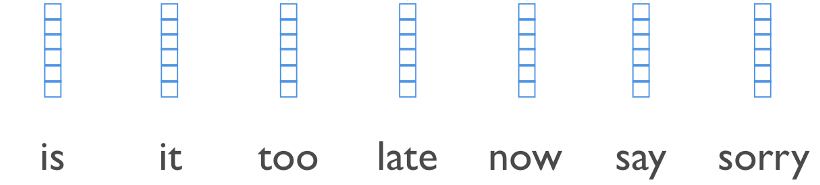

This input is much richer than the Bag of word or Tf-Idf document vectorization:
* We keep the information of the order of the words.
* Each word's vector contains a contextual information about the word
<br><br>
The dimension on the inputs should be the same so we will have to truncate the too long documents and complete the too short documents with null vectors.

<ipython-input-66-975d4e36aab0>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False, rug=True)


<Axes: >

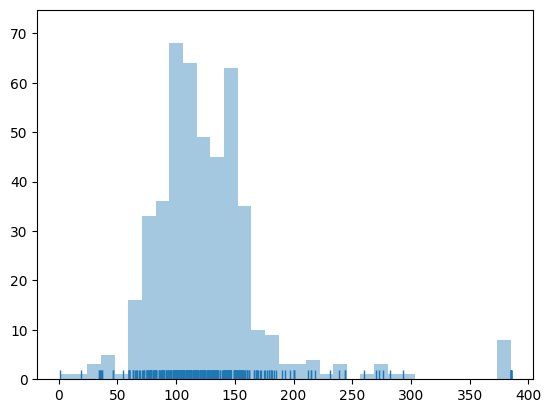

In [ ]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X)), display_id=True)
for ii, txt in enumerate(X):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X)))

sns.distplot(sizes, kde=False, rug=True)

First, we set the hyper parameters of the pre-processing phase.

In [ ]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

Then, we load the standford glove.6B.50d pretrained word2vec.

In [ ]:
word2vec_g = load_word2vec(glove_word2vec)

We could also use our own word2vec to vectorize the words. Both word2vec has their advantages and disadvantages. <br>
I encourage you to test both vectorization and observe the impact on the performance of the classification. <br><br>
We start the feature creation by assigning a unique index to each word in the vocabulary of the corpus and transform the texts to a list of word index.


In [ ]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_test)

In [ ]:
print('Text : '+X_train[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : unlike individual debt securities typically pay principal maturity value investment fund fluctuate could lose money investing fund may also receive taxable distributions attributable fund 's sale municipal bonds may buy sell shares various ways internet institutional.fidelity.com phone reach fidelity representative mail fidelity investments p.o may qualify sales charge discounts family invest agree invest future least fund certain fidelity® funds managing fund similar overall interest rate risk compared customized municipal bond index representing fidelity management research company fmr 's view performance fund competitive universe
Index sequences : [494, 327, 85, 5, 603, 220, 88, 284, 11, 6, 1, 417, 52, 163, 87, 34, 1, 2, 43, 381, 671, 171, 1166, 1, 46, 158, 164, 119, 2, 182, 44, 17, 98, 495, 545, 246, 115, 99, 546, 672, 115, 432, 604, 115, 18, 183, 641, 2, 274, 120, 132, 190, 205, 27, 275, 27, 149, 174, 1, 54, 112, 9, 932, 1, 116, 394, 16, 24, 3, 1167, 1284, 164, 23, 12, 1285

'Companies' has the index 41, 'may' 3 and so forth<br><br>

Then we use the pad_sequence function provided by keras to truncate or lengthen (by adding zeros) each text so they all have the same length : 150

In [ ]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [ ]:
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 86
length of the paded first sequence : 150


Finally, we create our embedding matrix. This is a (2500,50) array filled with the vector's representation of the words in our vocabulary. The line i is the vector representation of the word that has the index i.

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_g.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix[2]

array([ 0.70480001,  0.22261   ,  0.086997  , -0.21241   , -0.089356  ,
        0.43742001, -0.28169999,  0.13378   , -0.50858998, -0.18242   ,
        0.49506   ,  0.42460999,  0.046785  , -0.50120997,  0.84621   ,
        1.01460004, -0.43954   , -0.65499002, -0.64705998, -0.23365   ,
        0.27612001, -0.63293999,  0.91064   ,  0.033327  , -0.058451  ,
       -1.60590005, -0.34740999, -0.36285001,  0.46722999,  0.244     ,
        3.42490005,  0.056168  , -0.71991003, -0.88331997,  0.33741   ,
       -0.53236002,  0.33991   ,  0.023837  ,  0.2384    , -0.38712999,
       -0.49621001, -0.14846   ,  0.046201  ,  0.10325   ,  0.17374   ,
        0.13763   ,  0.084989  , -0.39688   ,  0.17632   ,  0.31862   ])

In [ ]:
embedding_matrix.shape

(2183, 50)

In [ ]:
len(word_index) + 1

2183

In [ ]:
word_dimension

50

Now that each text has been translated to a 150 long vector of word indexes and that we have a matrix that transform a word index to its vector representation, we are ready to implement the deep learning models.

<h3>3_ First Model : One dimensional Convolutional Neural Network</h3>

Before jumping in to the implementation of the model, we should take a moment to understand how a Convolutional Neural Network (CNN) works and why is it well adapted for text classification.

<b>What is a 1 dimensional Convolutional Neural Network ?</b>

Convolutional Neural Networks has first been developed for computer visions problems. The main idea is to break down a given image to a set meaningful new images by applying different filters to this image. Please find bellow an example of 2 filters applied to the same image.

<u>Original Image</u> :

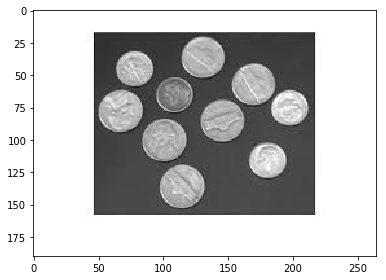

<u>Filtered Images</u> :

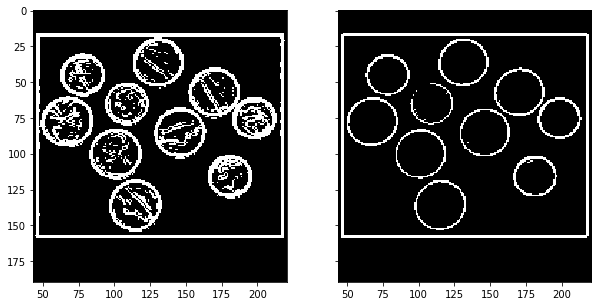

By applying different filters, we can highlight different local aspects of the picture. The training of a CNN classifier consists in optimizing these filters so that the outputted images highlight the best features to perform the classification. For more details on how we apply the filters, how the optimization system optimize the filters and how the outputted images are then used to perform the classification I invite you to read this paper : https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

<b>For texts </b> the idea is the same: we train the model to optimize filters that goes through the documents and search for local patterns that best highlight the information we want to extract. For images, the patterns are highlighted by applying filters on the colour’s intensity nuances and for texts the filters are applied on the contextual vectors of the words in the sentences.

<b>Why are CNNs well adapted for text classification ?</b>

The same reasons that makes CNNs very efficient for image classification applies to text classification. 1-DCNNs extract features from local input patches allowing for representation modularity.1D convolution layers are also translation invariant in the sense that because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized at a different position.

<b>a_ Training of the CNN</b>


In [ ]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length=maxlen, trainable=False))

    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 1, activation = 'sigmoid'))

    CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return CNN

In [ ]:
CNN_model = create_CNN_model()

In [ ]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
24/24 [==============================] - 11s 78ms/step - loss: 0.6793 - accuracy: 0.6086 - val_loss: 0.5334 - val_accuracy: 0.7447
Epoch 2/10
24/24 [==============================] - 0s 14ms/step - loss: 0.4351 - accuracy: 0.8123 - val_loss: 0.3873 - val_accuracy: 0.8511
Epoch 3/10
24/24 [==============================] - 1s 39ms/step - loss: 0.2703 - accuracy: 0.9088 - val_loss: 0.3905 - val_accuracy: 0.8617
Epoch 4/10
24/24 [==============================] - 0s 6ms/step - loss: 0.1931 - accuracy: 0.9491 - val_loss: 0.4052 - val_accuracy: 0.8404
Epoch 5/10
24/24 [==============================] - 0s 6ms/step - loss: 0.1490 - accuracy: 0.9544 - val_loss: 0.2480 - val_accuracy: 0.9149
Epoch 6/10
24/24 [==============================] - 0s 8ms/step - loss: 0.1282 - accuracy: 0.9625 - val_loss: 0.3390 - val_accuracy: 0.8723
Epoch 7/10
24/24 [==============================] - 0s 6ms/step - loss: 0.0754 - accuracy: 0.9866 - val_loss: 0.2432 - val_accuracy: 0.9043
Epoch 8/10
24/24

Some visualizations of the training :

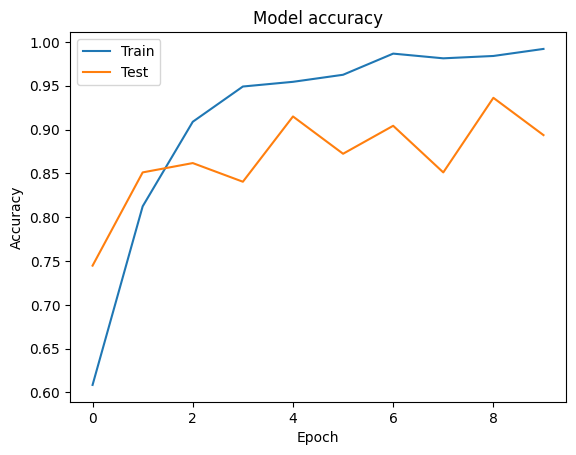

In [ ]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

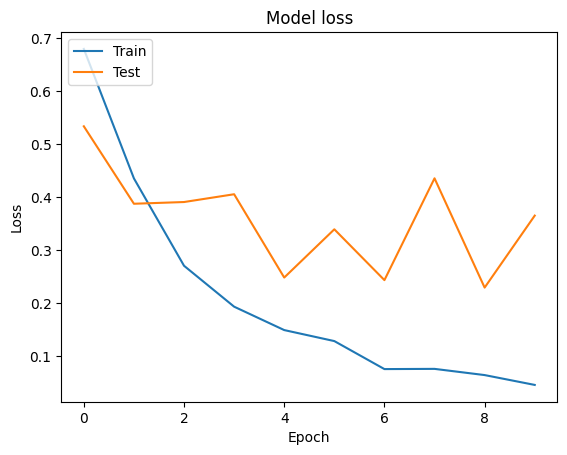

In [ ]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


<b>b_ Evalutation</b>



We can use the ROC curve to assess the performance of the classification. You can learn more about the ROC curve here :https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [ ]:
y_pred_CNN = CNN_model.predict(feature_test)

3/3 [==============================] - 0s 49ms/step


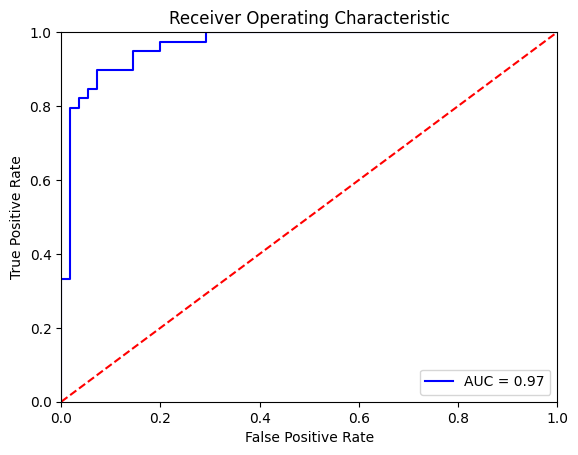

In [ ]:
fpr, tpr, threshold =roc_curve(y_test, y_pred_CNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h3>4_ Second Model : Recurrent Neural Networks</h3>

Like for the CNN, lets first take a close look at how does a Recurrent Neural Network (RNN) works and why is this type of model actually well adapted to texts classification.

<b>What is a RNN and how does it work ?</b><br>
An RNN is a specific kind of neural network that have the following two properties:
* They make use of sequential information.
* They have a memory that captures what have been calculated so far.
<br><br>
For a given document, the RNN layer takes each word sequentially and at a given word, build a vector that combines the information of the current word with the information of all the preceding words. When the layer when through all the document, the output vector reflects the information of each words of the documents taken sequentially.
<br>
The optimisation of this layer tends to find the best way to understand the sequence of words in order to answer the final question: is the fund using derivatives.
<br><br>
What does it mean mathematically ?
<br>
I our case the words have 50 dimensions and a document is composed of 150 words. Let’s xt be the t-th word of a given document. A document could be written as followed:
$$
[x_1,x_2\ ,...,x_{t-1},x_t,x_{t+1},...\ ,x_{250}\ ]
$$
for t going from 1 to 250, the RNN layer compute sequentially:
$$
h_t=f(W*x_t+U*h_{t-1}+b)
$$
Where f is a nonlinear activation function and b the bias.
<br>
The training aimed at searching the best W, U and b such that the output of this layer gives the best information for answering our question.
<br>
The output of the layer is h250. It contains the combined information of each words of the document taken sequentially. This output is used as the input of a feedforward classifier that performs the classification.
<br>
You will find a great illustrated more detailed explanation of the recurrent neural network here: https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9



<b>Why this is a good algo for text classification ?</b><br>
The main advantage of this kind of neural network is that it allows to understand inputs as an ordered series. RNN has been widely used for time series analysis. You can find for instance find many papers exploring Stock predictions using deep recurrent neural networks (https://www.scitepress.org/papers/2018/67499/67499.pdf).
<br>
RNNs has been found very efficient for text classification and more generally for text understanding and processing. The sequential nature of languages could explain why RNNs are well adapted. Indeed, it seems more logical to understand alphabetic sentences as sequences than simply as unordered list of words such as in the ML algorithms we discussed above.



<b>RNN or Bidirectional LSTM? what's the difference? </b><br>
You will see in the implementation of the model that we use a Bidirectional LSTM layer instead of a simple RNN layer. What is the difference?
<br>
* <b>Bidirectional</b>
means that instead of only reading the sentence from left to right, also build a vector reading from left to right and concatenates both outputs.
<br>
(see https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks for more details)




<u>Schema of a One direction RNN layer :</u>

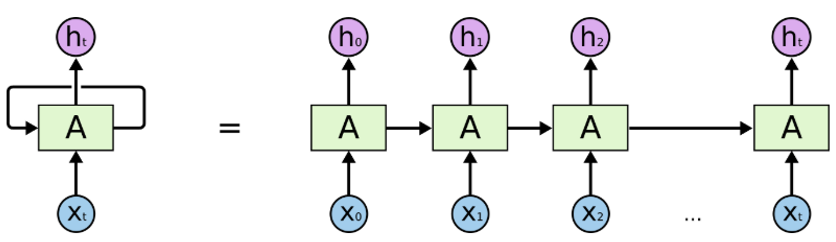

<u>Schema of a Bidirectional RNN layer :</u>

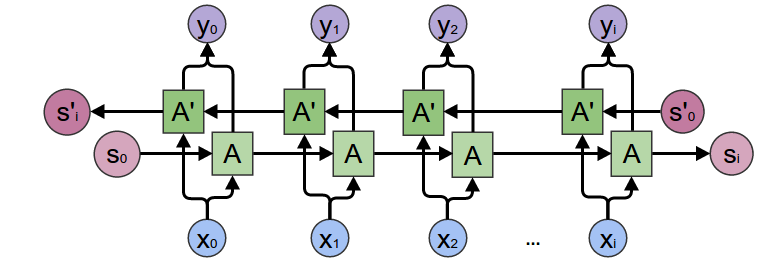

* <b>LSTM vs RNN?</b><br>
It appears that RNNs have a strong theorical limit called "Vanishing gradient". It can be shown that for long series, RNN models can't be well optimized. LSTM layers have been developed to address this issue. for more details on the vanishing gradient problem and how it has been addressed, please look at this paper: https://medium.com/datadriveninvestor/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577


<b>a_ training of the RNN</b>

In [ ]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(1, activation='sigmoid'))
    RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return RNN

In [ ]:
RNN_model = create_RNN_model()

In [ ]:
RNN_history = RNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
24/24 [==============================] - 5s 55ms/step - loss: 0.6471 - accuracy: 0.6300 - val_loss: 0.5946 - val_accuracy: 0.7447
Epoch 2/10
24/24 [==============================] - 0s 15ms/step - loss: 0.5433 - accuracy: 0.7748 - val_loss: 0.4260 - val_accuracy: 0.8511
Epoch 3/10
24/24 [==============================] - 0s 17ms/step - loss: 0.3497 - accuracy: 0.8445 - val_loss: 0.2935 - val_accuracy: 0.9043
Epoch 4/10
24/24 [==============================] - 0s 21ms/step - loss: 0.2641 - accuracy: 0.9008 - val_loss: 0.2923 - val_accuracy: 0.8617
Epoch 5/10
24/24 [==============================] - 1s 21ms/step - loss: 0.2623 - accuracy: 0.8874 - val_loss: 0.2054 - val_accuracy: 0.9362
Epoch 6/10
24/24 [==============================] - 1s 21ms/step - loss: 0.1817 - accuracy: 0.9330 - val_loss: 0.1873 - val_accuracy: 0.9468
Epoch 7/10
24/24 [==============================] - 1s 21ms/step - loss: 0.1637 - accuracy: 0.9437 - val_loss: 0.2090 - val_accuracy: 0.9362
Epoch 8/10
24


Some visualizations of the training :


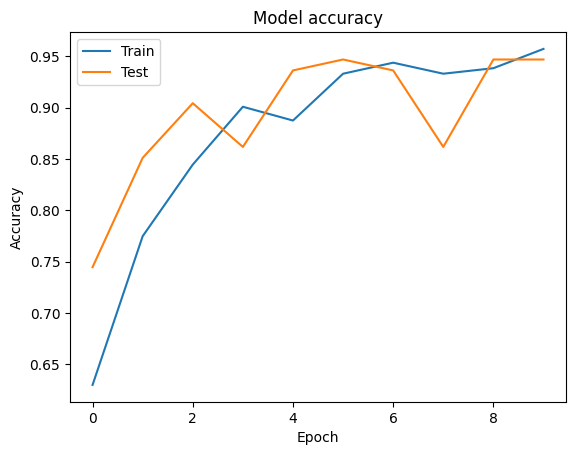

In [ ]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

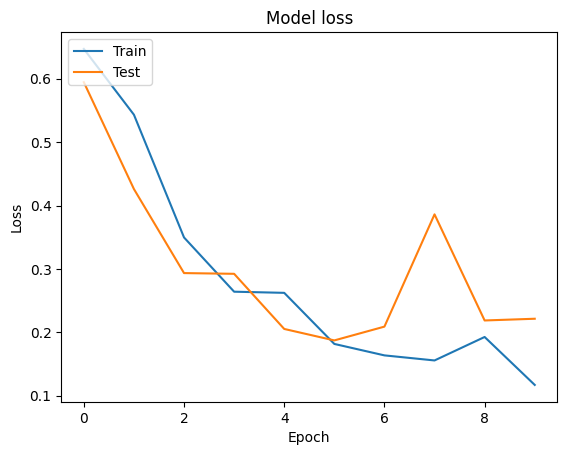

In [ ]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<b>b_ Evaluation</b>

In [ ]:
y_pred_RNN = RNN_model.predict(feature_test)

3/3 [==============================] - 1s 11ms/step


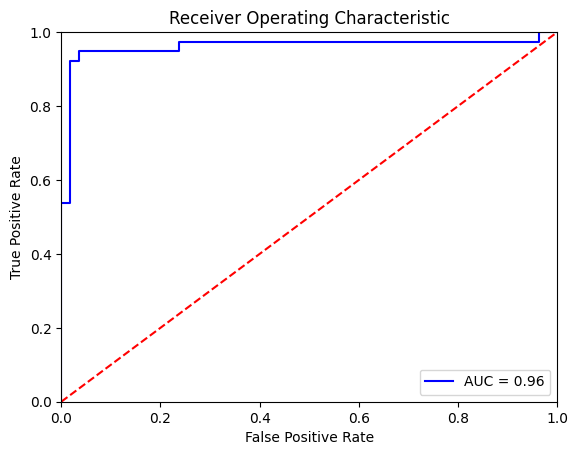

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_RNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion

This Notebooks propose an implementation of some of the most famous algorithms used in NLP. NLP is vast and is growing very fast, I discuss below some other important models.

There is a great diversity of pre-built nlp tools such as Parsing models and linguistic models. You can find a great variety of open source software and libraries that propose such models.</br>
The following link gives a list of such opensource tools :</br>
https://opensource.com/article/19/3/natural-language-processing-tools
</br></br>

Moreover, NLP is in constant evolution. The Bert model, for instance, has been developed in late 2018 and gives spatial word representation that contains much more contextual information than the ones outputted by the skip-gram model. Recent papers show that Bert allows to out-perform the previous word2vec approaches in text classification. To learn more about the Bert model I invite you to follow the link below.
https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
